# Streamgraph Corpus
This notebook takes you through making a streamgraph from a directory of multiple .txt files.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED.    

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by simply typing "pip install nameofpackage --user" (minus the quotes). 


- **nltk:** A leading platform for building Python programs to work with human language data.
- **string:** Contains a number of functions to process standard Python strings.
- **math:** Provides access to the mathematical functions defined by the C standard.
- **numpy:** The fundamental package for scientific computing with Python.
- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
- **os:** This module provides a portable way of using operating system dependent functionality.
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **scipy:** Open-source software for mathematics, science, and engineering. The SciPy library depends on NumPy, which provides convenient and fast N-dimensional array manipulation.
- **ggplot:** a Python implementation of the grammar of graphics.

In [1]:
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
import string
import math
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join, isfile, splitext
import pandas as pd
from scipy.stats import rankdata
from ggplot import *

### Functions
We need to create functions in order to calculate and create a streamgraph. Any time you see 'def' (without the quotes) that means we are DEclaring a Function. The 'def' is usually followed by the name of the function being created and then in parentheses are the arguments the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed or in other words what the function is doing. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required arguments in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

#### Text Cleaning

These functions do some text cleaning for us and require the arguments: 'token' for the allPuncChar function and 'words, customStopWordsList = None'. The =None means that the default is that there is no additional stopwords list, so if you put nothing, it will automatically assume there is no other stopwords list.

This function removes punctuation and is used as part of the text cleaning function

In [2]:
def allPuncChar(token):
    
    for c in token:
        
        if c not in string.punctuation:
            return False
        
    return True

Now we come to the text cleaning function. First we lowercase the text or else 'Love' and 'love' will be counted as two different words, so we make them all 'love'. 

Then we remove stopwords. If you wish to use a stopword list of a language other than English, simply replace 'english' (with the quotes this time) in the cell below with the anglicized name of your language of interest (meaning 'spanish' instead of 'espanol' and 'german' instead of 'deutsch'). There is a limit to the languages available using NLTK's stopwords. The list of available languages can be found by running the code: 'stopwords.fileids()' (without the quotes).

Lastly we remove punctuation and numbers and return a list of cleaned words.

In [3]:
def clean(words, customStopWordsList = None):
    ################
    # cleanup
    ################

    # to lower case
    words = [w.lower() for w in words]


    # remove stop words

    # step 1: custom list
  
    if customStopWordsList is not None:
        words = [w for w in words if w not in customStopWordsList]


    # step 2: built in list
    builtinList = set(stopwords.words('english')) # convert from list to set for fast lookup
    words = [w for w in words if w not in builtinList]

    # remove punctuations
    words = [w for w in words if not allPuncChar(w)]


    # remove numbers
    words = [w for w in words if not w.isnumeric()]
    
    return words
    

### Read in the corpus

Here we read in the corpus we are going to use. The first three lines are where you are going to make your changes. The first line assigns the file path to the directory where your corpus folder or folders are stored and is assigned to the variable 'root'. The next line points to the folder containing your files and is assigned to the variable 'dataHome'. We did this in case your corpus is contained in mutiple folders and not just one. Finally, the 'filepath' variable contains the filepath to any additional stopwords you might have made and saved as a .txt file. These three lines are the only ones you will most likely need to change.

In [4]:
root = '/N/u/klosteda/Carbonate/Text-Analysis/data/StarTrekNextGenClean'

dataHome = 'season1'

# load custom stop words list
filepath = "/N/u/klosteda/Carbonate/Text-Analysis/data/earlyModernStopword.txt"

with open(filepath) as f:
     lines = f.read().splitlines()

customStopWordsList = set([l.strip() for l in lines]) # convert from list to set for fast lookup

# loop over text files
filenames = [f for f in os.listdir(os.path.join(root, dataHome)) if isfile(os.path.join(root, dataHome, f))]

filenames = sorted(filenames, key = lambda x: str(splitext(x)[0]))

docs = []

for filename in filenames:

    doc = PlaintextCorpusReader(join(root, dataHome), filename, encoding = 'ISO-8859-1')

    # get tokens
    words = doc.words()

    words = clean(words, customStopWordsList)
    
    docs.append(words)

### Pick words of interest
Here we decide what words we are most interested in seeing in the streamgraph. Just add any words with quotes and separated by a comma. There is no limit to how many words you can look at. However, at some point the graph may become difficult to read if you put too many words, so keep that in mind.

In [5]:
# calculate frequency

interestedWords = ['yar', 'troi', 'crusher']

freqDict = {}

for w in interestedWords:
    
    freqDict[w] = np.zeros(len(docs)).tolist()
    
for idx, doc in enumerate(docs):
    
    for token in doc:
        
        if token in freqDict:
            freqDict[token][idx] += 1

### Emulate R's stat_steamgraph in 'ggTimeSeries' package

This function is meant to emulate the stat_steamgraph function from the ggTimeSeries package in R. You will most likely not need to make any changes here. This function is creating a special data frame (kind of like an excel table) for ggplot to be able to read it in a way that it creates a streamgraph from the data.

In [6]:
def composeDataframe(freqDict, debug = False):

    if debug:
        df = pd.DataFrame(data = freqDict)
        print(df)
        print('\n' * 3)


    wordCol = []
    freqCol = []
    seqNum = []
    
    for word in freqDict:
        wordCol.extend([word] * len(freqDict[word]))
        freqCol.extend(freqDict[word])
        seqNum.extend(list(range(1, len(freqDict[word]) + 1)))

    dataDict = {"Term" : wordCol, "Freq" : freqCol, 'SeqNum' : seqNum}

    df = pd.DataFrame(data = dataDict)

    if debug:
        print(df)
        print('\n' * 3)

    rankdf = df.groupby(["Term"], as_index = False).agg({"Freq" : "std"}).rename(columns = {"Freq" : "Std"})

    if debug:
        print(df)
        print('\n' * 3)

    rankdf["StdRank"] = rankdata(rankdf["Std"], method = 'ordinal')

    if debug:
        print(rankdf)
        print('\n' * 3)

    for idx, row in rankdf.iterrows():

        if row["StdRank"] % 2 == 0:
            rankdf.at[idx, "StdRank"] = -row["StdRank"]


    if debug:
        print(rankdf)
        print('\n' * 3)

    df = df.merge(rankdf, on = 'Term')

    if debug:
        print(df)
        print('\n' * 3)

    df = df.sort_values(by = ['SeqNum', 'StdRank'])

    if debug:
        print(df)
        print('\n' * 3)

    def f(x):

        x["cumsum"] = x["Freq"].cumsum()
        x["ymax"] = x["Freq"].cumsum() - x["Freq"].sum() / 2
        x["ymin"] = x["ymax"] - x["Freq"]

        return x


    df = df.groupby(["SeqNum"], as_index = False).apply(f)

    if debug:
        print(df)
        print('\n' * 3)
        
    return df


Now we apply the emulator data frame function from above to our corpus so we can plot the streamgraph in our next block of code. Again, it is unlikely that you will need to make changes here.

In [7]:
df = composeDataframe(freqDict)

seqLabel = []
seqNum = df["SeqNum"]

for i in seqNum:
    seqLabel.append(filenames[i - 1])
    
df["SeqLabel"] = seqLabel

### Plot the Streamgraph

For the code below, you will only need to make changes to five lines of code. The first is where it says 'scale_fill_brewer'. You may want to change the palette color to something else besides 'Dark2' (with the quotes). Some color options can be found [here](https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf) under RColorBrewer. Next you will want to change the xlab, ylab, and ggtitle lines to match your data. The xlab and ylab is where you can change the labels of the x and y axis. The size changes the font size and vjust changes the distance from the graph the label appears. Finally, you will want to change the file path in plt.savefig to match where you want a .png of the graph to be saved and what you want to name the file. Once you've made your changes, you're ready to plot your graph!

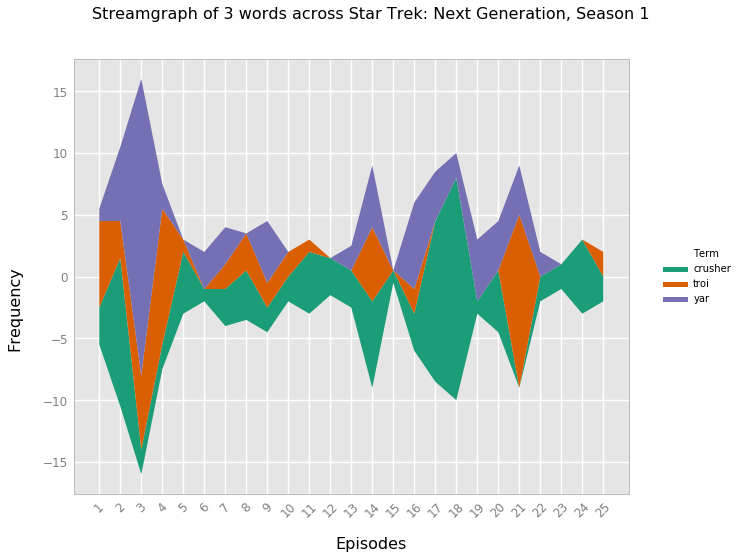

In [9]:
p = ggplot(df, aes(x = 'SeqNum', ymin = 'ymin', ymax = 'ymax', y = 'Freq', group = 'Term', fill = 'Term')) +\
    geom_ribbon() + \
    theme(axis_text_x = element_text(angle = 45, hjust = 1)) + \
    scale_fill_brewer(type = 'qual', palette = 'Dark2') + \
    xlab(element_text(text = "Episodes", size = 16, vjust = -0.02)) + \
    ylab(element_text(text = "Frequency", size = 16)) + \
    scale_x_discrete(breaks = list(range(1, len(docs) + 1))) + \
    ggtitle(element_text(text = "Streamgraph of 3 words across Star Trek: Next Generation, Season 1", size = 16))
p.make()
plt.savefig("/N/u/klosteda/Carbonate/Text-Analysis/Output/streamgraphStarTrek277Py.png", width = 14, height = 8, dpi = 800)

plt.show()

## VOILA!!